In [1]:
import pandas as pd
import numpy as np
import seaborn
import sentencepiece as spm
import matplotlib.pyplot as plt
import scipy.sparse
import shap
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from pandas import Series
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.neural_network import MLPClassifier
from gensim.parsing.preprocessing import remove_stopwords, strip_non_alphanum
from gensim.parsing.porter import PorterStemmer

In [2]:
job_posting = pd.read_csv('csv/job_postings_training_set.csv')
print(job_posting.columns)
print(job_posting.shape)
print(job_posting['fraudulent'].value_counts())

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')
(17828, 18)
0    16966
1      862
Name: fraudulent, dtype: int64


## 將特徵區分為下述幾種類型
* 數值型 (numerical)
* 文本型 (textual)
* 類別型 (categorical)

In [3]:
numerical = job_posting.select_dtypes(include=['number'])
textual = job_posting[['title', 'company_profile', 'description', 'requirements', 'benefits']]
categorical = job_posting.select_dtypes(include=['object']).drop(textual, axis=1)

In [4]:
print(f'categorical value distribution:\n\n {categorical.nunique()}\n')
print(f'numerical value distribution:\n\n {numerical.nunique()}\n')
print(f'textual value distribution:\n\n {textual.nunique()}\n')

categorical value distribution:

 location               3097
department             1337
salary_range            874
employment_type           5
required_experience       7
required_education       13
industry                131
function                 37
dtype: int64

numerical value distribution:

 job_id              17828
telecommuting           2
has_company_logo        2
has_questions           2
fraudulent              2
dtype: int64

textual value distribution:

 title              11188
company_profile     1707
description        14677
requirements       11881
benefits            6131
dtype: int64



### 將 value difference 數量少於 150 的做單因子 & 關聯性觀察

In [5]:
def feat_exploration(df, topN=5, data=job_posting):
    for feat in df:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        X = pd.cut(data[feat], topN) if feat == 'salary_range' else feat
        plot_order = None if feat == 'salary_range' else data[feat].value_counts().iloc[:topN].index
        
        ax1 = seaborn.countplot(x=X, data=data, ax=ax1, order=plot_order)
        ax1.tick_params(axis='x', labelrotation=90)

        # 關聯性觀察
        if feat == 'fraudulent':
            continue
            
        count_groupby_Y = (data.groupby([X])['fraudulent']
                           .value_counts()
                           .rename('count')
                           .reset_index()
                           .sort_values('fraudulent'))
        total_count = data['fraudulent'].value_counts().rename('total')
        counts_ratio = pd.merge(count_groupby_Y, total_count, how='left', left_on='fraudulent', right_index=True)
        counts_ratio['ratio'] = counts_ratio['count'] / counts_ratio['total'] 
        ax2 = seaborn.barplot(x=feat, y="ratio", hue="fraudulent", data=counts_ratio, ax=ax2, order=plot_order)
        ax2.tick_params(axis='x', labelrotation=90)
                

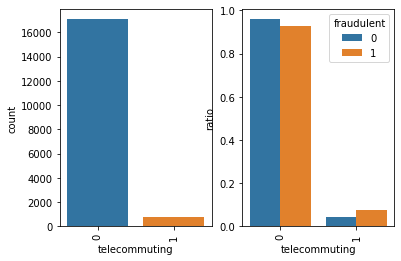

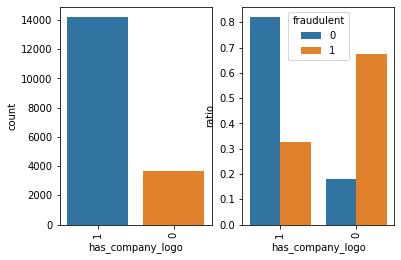

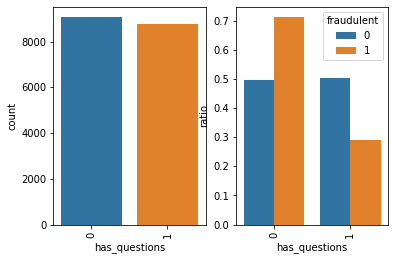

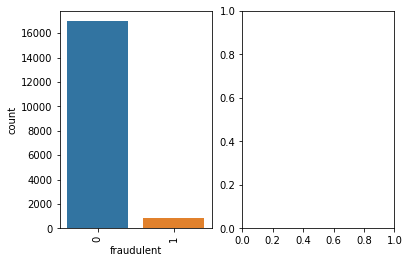

In [6]:
# Numerical features
critical = numerical.nunique() < 150
num_less150 = critical.index[critical]
feat_exploration(num_less150)

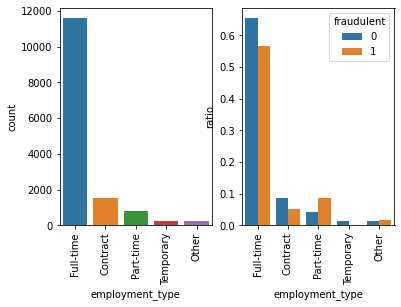

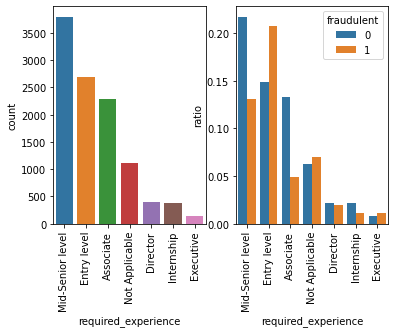

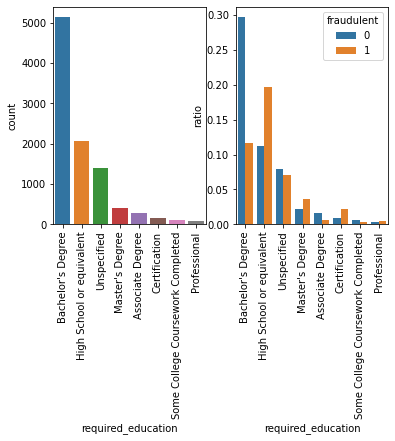

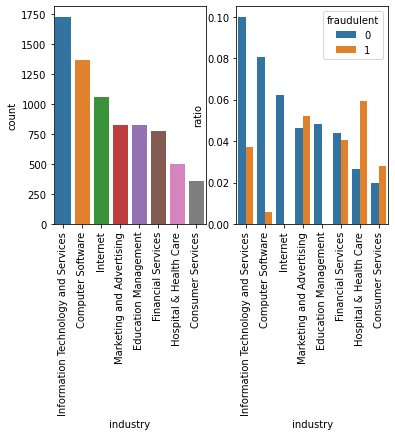

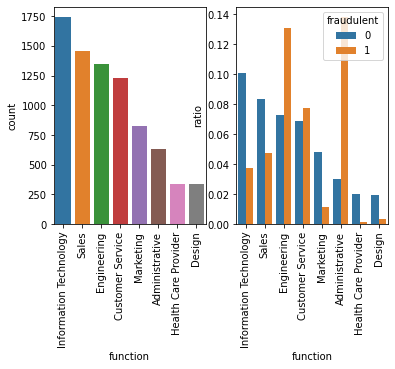

In [7]:
# Categorical features
critical = categorical.nunique() < 150
cate_less150 = critical.index[critical]
feat_exploration(cate_less150, topN=8)

### 將 value difference 大於 150 的 features 做各別前處理
* job_id -> 直接移除
* location -> `只取國家名稱`
* department -> 不調整
* salary_range -> `將薪資範圍平均，轉為數值型特徵`

In [8]:
def get_outliers(feat: Series, abnormal_range=1):
    mean = np.mean(feat)
    std = np.std(feat)
    print(f'mean: {mean}')
    print(f'std: {std}')
    outlier_idx = [idx for idx, x in enumerate(feat) 
                   if ((x - mean) / std > abnormal_range or (x - mean) / std < -abnormal_range)]
    upper_bound = mean + abnormal_range * std
    lower_bound = mean - abnormal_range * std
    return outlier_idx, upper_bound, lower_bound, mean

In [9]:
def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

In [10]:
# location
job_posting_pre = job_posting[:]
job_posting_pre['location'] = job_posting['location'].str.split(",", n=1, expand=True)[0]

# salary_range
salary = job_posting['salary_range'].str.split("-", n=1, expand=True)
salary = salary[salary.applymap(isnumber)].astype('float32')
job_posting_pre['salary_range'] = (salary[0] + salary[1]) / 2

# Repalce outlier salary to boundary salary
outlier_idx, upper_bound, _, mean = get_outliers(job_posting_pre['salary_range'], abnormal_range=0.04)
print(f'upper_bound: {upper_bound}')
job_posting_pre.loc[outlier_idx, 'salary_range'] = upper_bound
# Replace zero salary to mean salary
job_posting_pre['salary_range'] = job_posting_pre['salary_range'].replace(0, mean)

# job_id
job_posting_pre = job_posting_pre.drop('job_id', axis=1)

mean: 665389.0
std: 22393228.0
upper_bound: 1561118.12


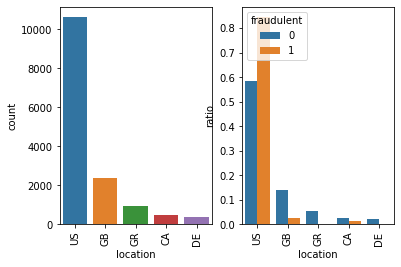

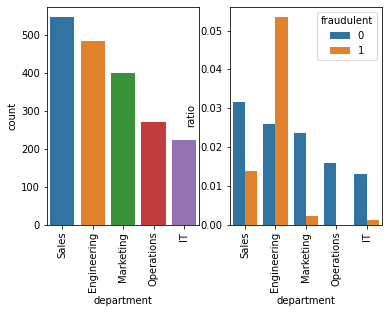

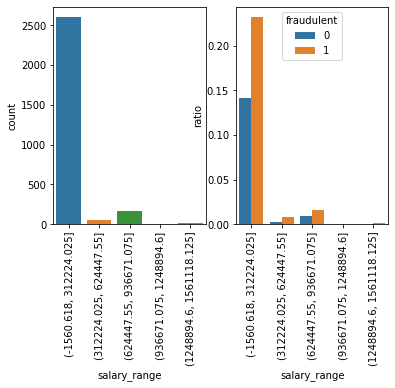

In [11]:
cate_large150 = ['location', 'department', 'salary_range']
feat_exploration(cate_large150, topN=5, data=job_posting_pre)

### 對文本與類別資料做前處理
`textual`
1. Remove stop_word
2. strip_non_alphanum
3. tokenizer
4. Stemming

`categorical`
1. 類別轉數值

### Remove Stopword & non_alphanum

In [12]:
textual = textual.replace(np.nan, '')
for col in textual.columns:
    temp_list = [remove_stopwords(seq) for seq in textual[col]]
    temp_list = [strip_non_alphanum(seq) for seq in temp_list]
    textual[col] = temp_list

### tokenizer by sentencepiece
https://github.com/google/sentencepiece

In [13]:
textual_list = textual.values.tolist()
corpus = [item for sublist in textual_list for item in sublist]

In [14]:
import io
model = io.BytesIO()
spm.SentencePieceTrainer.train(sentence_iterator=iter(corpus),
                               model_writer=model,
                               split_by_whitespace=True,
                               split_by_number=False,
                               max_sentencepiece_length=512,
                               add_dummy_prefix=False,
                               vocab_size=50000)
sp = spm.SentencePieceProcessor(model_proto=model.getvalue())
print(sp.encode(['this is test'], out_type=str))


[['th', 'is', '▁is', '▁test']]


In [15]:
tokenizer_df = pd.DataFrame()
for col in tqdm(textual.columns):
    #tokenizer_df[col] = textual[col]   ## Show origin feature
    tokenizer_df[f'{col}_token'] = sp.encode(textual[col].tolist(), out_type=str)
    temp_list = []
    for tokens in tokenizer_df[f'{col}_token']:
        temp_list.append([word.replace('▁', '') for word in tokens])
        
    tokenizer_df[f'{col}_token'] = temp_list

100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


In [16]:
tokenizer_df.head(3)

,title_token,company_profile_token,description_token,requirements_token,benefits_token
0,"[Marketing, Intern]","[We, re, Food52, we, ve, created, ground, brea...","[Food52, fast, growing, James, Bear, d, Award,...","[Experience, content, management, systems, maj...",[]
1,"[Customer, Service, Cloud, Video, Production]","[90, Seconds, worlds, Cloud, Video, Production...","[Organised, Focused, Vibra, nt, Awesome, Do, p...","[What, expect, you, Your, key, responsibility,...","[What, us, Through, 90, Seconds, team, gain, e..."
2,"[Commission, ing, Machine, ry, Assistant, CMA]","[Valor, Services, provides, , Workforce, Solut...","[Our, client, located, Houston, actively, seek...","[Implement, pre, commissioning, commissioning,...",[]


### Stemming

In [17]:
porter_stemmer = PorterStemmer()

# Get the stemmed_tokens
for col in tqdm(tokenizer_df.columns):
    tokenizer_df[col] = [[porter_stemmer.stem(word) for word in tokens] for tokens in tokenizer_df[col]]

tokenizer_df.head(3)

100%|██████████| 5/5 [00:27<00:00,  5.48s/it]


,title_token,company_profile_token,description_token,requirements_token,benefits_token
0,"[market, intern]","[we, re, food52, we, ve, creat, ground, break,...","[food52, fast, grow, jame, bear, d, award, win...","[experi, content, manag, system, major, plu, a...",[]
1,"[custom, servic, cloud, video, product]","[90, second, world, cloud, video, product, ser...","[organis, focus, vibra, nt, awesom, do, passio...","[what, expect, you, your, kei, respons, commun...","[what, us, through, 90, second, team, gain, ex..."
2,"[commiss, ing, machin, ry, assist, cma]","[valor, servic, provid, , workforc, solut, mee...","[our, client, locat, houston, activ, seek, exp...","[implement, pre, commiss, commiss, procedur, r...",[]


In [18]:
job_posting_pre = job_posting_pre.drop(textual.columns, axis=1)
job_posting_pre.head(3)

,location,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,US,Marketing,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,NZ,Success,NaN,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,US,NaN,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


### 類別轉數值

In [19]:
def category_to_num(df):
    df = df.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'bool' or x.dtype == 'object' else x)
    return df

In [20]:
job_posting_pre = category_to_num(job_posting_pre)
job_posting_pre.head(3)

,location,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,0,NaN,0,1,0,0,0,-1,-1,0,0
1,1,1,NaN,0,1,0,1,1,-1,0,1,0
2,0,-1,NaN,0,1,0,-1,-1,-1,-1,-1,0


### fill NaN to 0 & normalization

In [21]:
# fill NaN to 0
job_posting_pre = job_posting_pre.fillna(0)

# normalization via mixmax scale
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(job_posting_pre.values)
job_posting_pre = pd.DataFrame(x_scaled, columns=job_posting_pre.columns)
job_posting_pre.head(3)

,location,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0.011111,0.000748,0.0,0.0,1.0,0.0,0.2,0.142857,0.0,0.000000,0.027027,0.0
1,0.022222,0.001496,0.0,0.0,1.0,0.0,0.4,0.285714,0.0,0.007634,0.054054,0.0
2,0.011111,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0


In [22]:
job_posting_pre = pd.concat([job_posting_pre, tokenizer_df], axis=1)
job_posting_pre.head(3)

,location,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,title_token,company_profile_token,description_token,requirements_token,benefits_token
0,0.011111,0.000748,0.0,0.0,1.0,0.0,0.2,0.142857,0.0,0.000000,0.027027,0.0,"[market, intern]","[we, re, food52, we, ve, creat, ground, break,...","[food52, fast, grow, jame, bear, d, award, win...","[experi, content, manag, system, major, plu, a...",[]
1,0.022222,0.001496,0.0,0.0,1.0,0.0,0.4,0.285714,0.0,0.007634,0.054054,0.0,"[custom, servic, cloud, video, product]","[90, second, world, cloud, video, product, ser...","[organis, focus, vibra, nt, awesom, do, passio...","[what, expect, you, your, kei, respons, commun...","[what, us, through, 90, second, team, gain, ex..."
2,0.011111,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,"[commiss, ing, machin, ry, assist, cma]","[valor, servic, provid, , workforc, solut, mee...","[our, client, locat, houston, activ, seek, exp...","[implement, pre, commiss, commiss, procedur, r...",[]


### Train/Test split

In [23]:
def data_split(df, ratio=0.9, seed=0):
    train, test = train_test_split(
        df, train_size=ratio, random_state=seed, stratify=df['fraudulent'])
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
    return train, test

In [24]:
train, test = data_split(job_posting_pre)

In [25]:
print(train.shape)
print(train['fraudulent'].value_counts())

(16045, 17)
0.0    15269
1.0      776
Name: fraudulent, dtype: int64


In [26]:
print(test.shape)
print(test['fraudulent'].value_counts())

(1783, 17)
0.0    1697
1.0      86
Name: fraudulent, dtype: int64


### TF-IDF transformation for textual features

In [27]:
X_token = []
vectorizer_dict = {}
for col in train[tokenizer_df.columns]:
    vectorizer = TfidfVectorizer(analyzer=lambda x:x, max_features=100)
    vectorizer.fit(train[col])
    vectorizer_dict[col] = vectorizer
    X_token.append(vectorizer.transform(train[col]))

X_token = scipy.sparse.hstack(X_token)

### Concat [sparse matrix, numerical, categorical] features to X 

In [28]:
cols = []
for k, v in tqdm(vectorizer_dict.items()):
    cols.extend([f'{k}_{name}' for name in v.get_feature_names()])
X = pd.DataFrame.sparse.from_spmatrix(X_token, columns=cols)

100%|██████████| 5/5 [00:00<00:00, 11137.29it/s]


In [29]:
train = train.drop(tokenizer_df.columns, axis=1)
Y = train['fraudulent']
X = pd.concat([train, X], axis=1).drop('fraudulent', axis=1)
X.head(3)

,location,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,...,benefits_token_us,benefits_token_vacat,benefits_token_vision,benefits_token_want,benefits_token_we,benefits_token_work,benefits_token_world,benefits_token_y,benefits_token_year,benefits_token_you
0,0.011111,0.002244,0.0,0.0,1.0,1.0,0.4,0.428571,0.076923,0.038168,...,0.0,0.169370,0.000000,0.0,0.267998,0.121737,0.0,0.000000,0.000000,0.331838
1,0.011111,0.000000,0.0,0.0,1.0,0.0,0.4,0.428571,0.076923,0.045802,...,0.0,0.237639,0.000000,0.0,0.000000,0.000000,0.0,0.133805,0.132249,0.000000
2,0.011111,0.000000,0.0,0.0,1.0,1.0,0.4,0.571429,0.230769,0.137405,...,0.0,0.000000,0.235904,0.0,0.179706,0.163262,0.0,0.000000,0.000000,0.000000


### transform tf-idf to testing data

In [30]:
X_token = []
for col in test[tokenizer_df.columns]:
    vectorizer = vectorizer_dict[col]
    X_token.append(vectorizer.transform(test[col]))

X_token = scipy.sparse.hstack(X_token)

In [31]:
X_test = pd.DataFrame.sparse.from_spmatrix(X_token, columns=cols)
test = test.drop(tokenizer_df.columns, axis=1)
Y_test = test['fraudulent']
X_test = pd.concat([test, X_test], axis=1).drop('fraudulent', axis=1)
X_test.head(3)

,location,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,...,benefits_token_us,benefits_token_vacat,benefits_token_vision,benefits_token_want,benefits_token_we,benefits_token_work,benefits_token_world,benefits_token_y,benefits_token_year,benefits_token_you
0,0.011111,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.315477,0.0,0.0,0.0,0.000000,0.130209
1,0.044444,0.0,0.0,0.0,1.0,1.0,0.0,0.285714,0.230769,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,0.011111,0.0,0.0,0.0,1.0,1.0,0.4,0.714286,0.230769,0.519084,...,0.0,0.0,0.202022,0.0,0.000000,0.0,0.0,0.0,0.216505,0.000000


### baseline model (全猜0)

In [32]:
y_pred = [0] * len(X_test)
y_prob = [0] * len(X_test)

In [33]:
auc = roc_auc_score(Y_test, y_prob)
accuracy = accuracy_score(Y_test, y_pred)
print(f'AUC={auc} & Accuracy={accuracy}')

AUC=0.5 & Accuracy=0.9517666853617499


### training by XGBoost

In [34]:
xgbc = XGBClassifier().fit(X, Y)

[11:37:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [35]:
y_pred = xgbc.predict(X_test)
y_prob = xgbc.predict_proba(X_test)[:, 1]

In [36]:
auc = roc_auc_score(Y_test, y_prob)
accuracy = accuracy_score(Y_test, y_pred)
print(f'AUC={auc} & Accuracy={accuracy}')

AUC=0.9926683202916227 & Accuracy=0.9854178351093662


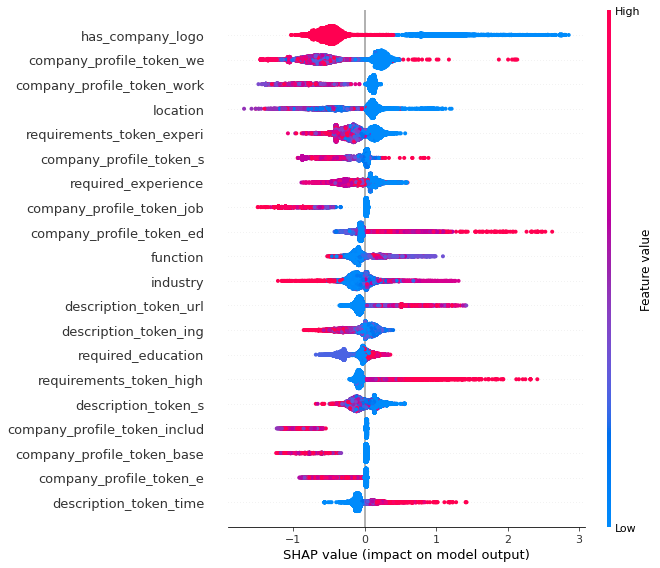

In [37]:
# feature importance
explainer = shap.TreeExplainer(xgbc)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=20)

### training by MLP

In [38]:
mlp = MLPClassifier(solver='adam',
                    activation='relu',
                    hidden_layer_sizes=(100,),
                    batch_size=200,
                    max_iter=20,
                    random_state=0,
                    verbose = True).fit(X, Y)

Iteration 1, loss = 0.21213171
Iteration 2, loss = 0.13017396
Iteration 3, loss = 0.09992508
Iteration 4, loss = 0.08003976
Iteration 5, loss = 0.06809092
Iteration 6, loss = 0.06014248
Iteration 7, loss = 0.05465265
Iteration 8, loss = 0.05006093
Iteration 9, loss = 0.04624350
Iteration 10, loss = 0.04299519
Iteration 11, loss = 0.03976421
Iteration 12, loss = 0.03706427
Iteration 13, loss = 0.03436094
Iteration 14, loss = 0.03166319
Iteration 15, loss = 0.02925470
Iteration 16, loss = 0.02711017
Iteration 17, loss = 0.02465770
Iteration 18, loss = 0.02249978
Iteration 19, loss = 0.02059869
Iteration 20, loss = 0.01904075


In [39]:
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:, 1]

In [40]:
auc = roc_auc_score(Y_test, y_prob)
accuracy = accuracy_score(Y_test, y_pred)
print(f'AUC={auc} & Accuracy={accuracy}')

AUC=0.9850488550245988 & Accuracy=0.9753224901850813
